In [10]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [11]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
BATCH_SIZE = 64
EPOCHS = 5
LR = 1e-3
NUM_TRAIN = 7291   # USPS train set size (approx)
IMAGE_SIZE = 16    # USPS images are 16x16
CHANNELS = 1       # USPS is grayscale

print("Using device:", DEVICE)

Using device: mps


In [12]:

class EnergyModel(nn.Module):
    """
    A deeper CNN to map [B,1,16,16] -> scalar energy [B].
    Feel free to expand or deepen further for better fidelity.
    """
    def __init__(self):
        super().__init__()
        # example: 3 conv layers => global average => final linear
        self.conv1 = nn.Conv2d(CHANNELS, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # final linear maps 128 -> 1, but we do a global average in forward
        self.fc = nn.Linear(128, 1, bias=False)

    def forward(self, x):
        # x shape: [B,1,16,16]
        h = F.relu(self.conv1(x))   # [B,32,16,16]
        h = F.relu(self.conv2(h))   # [B,64,16,16]
        h = F.relu(self.conv3(h))   # [B,128,16,16]
        # global average pool => [B,128]
        h = h.mean(dim=[2,3])       # average over H,W
        # final linear => [B]
        out = self.fc(h).squeeze(-1)
        return out  # E(x) : lower => higher probability



class GibbsSampler:
    """
    Single-site Gibbs for binary images in {0,1}.
    We update each pixel in raster order for 'steps' full sweeps.
    """
    def __init__(self, model: nn.Module):
        self.model = model

    @torch.no_grad()
    def sample(self, x0: torch.Tensor, steps: int = 10) -> torch.Tensor:
        """
        x0: [B,1,H,W], values in {0,1}
        steps: number of full sweeps over all pixels
        """
        self.model.eval()
        x = x0.clone().detach().to(DEVICE)
        B, C, H, W = x.shape
        for _ in range(steps):
            for r in range(H):
                for c in range(W):
                    # Evaluate E if pixel=0
                    x[:, 0, r, c] = 0.
                    e0 = self.model(x)
                    # Evaluate E if pixel=1
                    x[:, 0, r, c] = 1.
                    e1 = self.model(x)

                    # Probability pixel=1 ~ sigm(-(e1 - e0)) = 1 / [1+exp(e1 - e0)]
                    p1 = torch.sigmoid(-(e1 - e0))
                    coin = torch.rand_like(p1)
                    new_val = (coin < p1).float()
                    x[:, 0, r, c] = new_val
        return x


class LangevinSampler:
    """
    Overdamped Langevin MCMC for continuous [0..1] images.
    x_{t+1} = x_t - 0.5 * step_size * grad(E) + sqrt(step_size)*noise
    Then clamp to [0,1].
    """
    def __init__(self, model: nn.Module, step_size: float = 0.02, clip: bool=True):
        self.model = model
        self.step_size = step_size
        self.clip = clip

    def sample(self, x0: torch.Tensor, steps: int = 10) -> torch.Tensor:
        """
        x0: [B,1,H,W], float in [0,1]
        steps: number of langevin steps
        """
        self.model.eval()

        x = x0.clone().detach().to(DEVICE)
        x.requires_grad_(True)

        for _ in range(steps):
            energy = self.model(x).sum()
            energy.backward()

            with torch.no_grad():
                grad = x.grad
                x.data = x.data - 0.5 * self.step_size * grad
                x.data += math.sqrt(self.step_size) * torch.randn_like(x)
                if self.clip:
                    x.data.clamp_(0., 1.)

            x.grad.zero_()

        x.requires_grad_(False)
        return x.detach()




class PersistentBuffer:
    """
    Replay buffer that holds negative samples across epochs (PCD).
    """
    def __init__(self, size, shape, is_binary=False, device=DEVICE):
        """
        size: total number of samples to hold
        shape: (C,H,W) of an image
        is_binary: if True, round init to {0,1}
        """
        self.size = size
        self.is_binary = is_binary
        self.device = device
        # init random
        x = torch.rand(size, *shape, device=device)
        if is_binary:
            x = (x > 0.5).float()
        self.buffer = x

    def get(self, batch_size):
        idx = torch.randint(0, self.size, (batch_size,), device=self.device)
        return self.buffer[idx].clone(), idx

    def put(self, x_new, idx):
        self.buffer[idx] = x_new


In [13]:
def train_ebm(model, loader, optimizer, buffer, sampler, mcmc_steps=10, epochs=10):
    """
    We train by maximizing log-likelihood via naive gradient:
       d/dtheta [E_data(E(x)) - E_neg(E(x_neg))]
    With persistent replay of x_neg (PCD).
    """
    model.to(DEVICE)
    model.train()

    for epoch in range(1, epochs+1):
        total_loss = 0.0
        total_samples = 0

        pbar = tqdm(loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
        for real_x, _ in pbar:
            real_x = real_x.to(DEVICE)
            B = real_x.size(0)

            # E_pos
            E_pos = model(real_x).mean()

            # get negative from buffer
            x_neg, idx = buffer.get(B)

            # MCMC update
            x_neg = sampler.sample(x_neg, steps=mcmc_steps)

            # put back
            buffer.put(x_neg, idx)

            # E_neg
            E_neg = model(x_neg).mean()

            loss = E_pos - E_neg
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * B
            total_samples += B

        avg_loss = total_loss / total_samples
        print(f"[Epoch {epoch}/{epochs}] Avg Loss = {avg_loss:.4f}")



@torch.no_grad()
def show_images_grid(tensor_images, nrow=8, title="Samples"):
    import math
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid

    tensor_images = tensor_images[:(nrow*nrow)]
    grid = make_grid(tensor_images.cpu(), nrow=nrow, padding=2, pad_value=1.0)
    npgrid = grid.permute(1,2,0).numpy()

    plt.figure(figsize=(nrow, nrow))
    if npgrid.shape[-1] == 1:
        plt.imshow(npgrid[...,0], cmap='gray', vmin=0, vmax=1)
    else:
        plt.imshow(npgrid)
    plt.title(title)
    plt.axis('off')
    plt.show()




    print("Using device:", DEVICE)


Using device: mps
Using device: mps

--- EBM (Binary, Gibbs) ---


[Epoch 1/5] Avg Loss = -7.6217


[Epoch 2/5] Avg Loss = -5.8318


[Epoch 3/5] Avg Loss = -3.8487


[Epoch 4/5] Avg Loss = -1.9672


[Epoch 5/5] Avg Loss = -1.2572


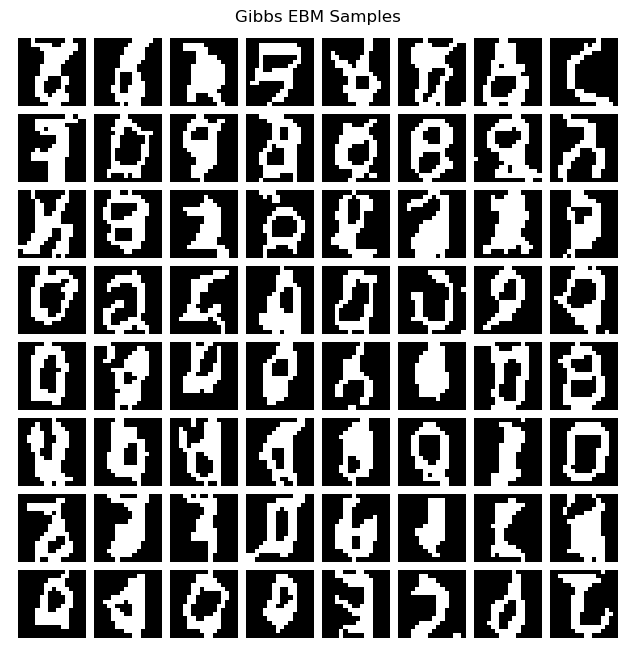


--- EBM (Continuous, Langevin) ---


[Epoch 1/5] Avg Loss = -41.3078


[Epoch 2/5] Avg Loss = -21077.0896


[Epoch 3/5] Avg Loss = -723529.6296


[Epoch 4/5] Avg Loss = -4593981.0942


[Epoch 5/5] Avg Loss = -15642771.5627


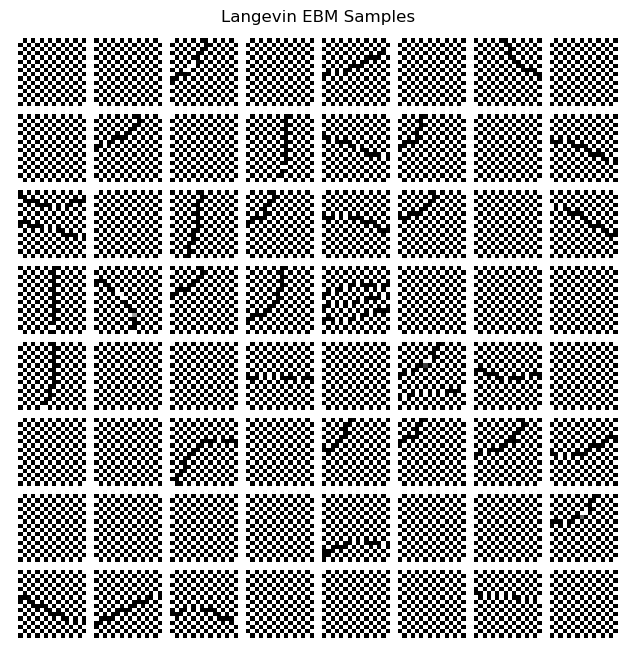

In [6]:


transform_bin = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x>0.5).float()),
])
transform_flt = transforms.ToTensor()

train_data_bin = datasets.USPS(root='.', train=True, download=True, transform=transform_bin)
train_data_flt = datasets.USPS(root='.', train=True, download=True, transform=transform_flt)

loader_bin = DataLoader(train_data_bin, batch_size=BATCH_SIZE, shuffle=True)
loader_flt = DataLoader(train_data_flt, batch_size=BATCH_SIZE, shuffle=True)


print("\n--- EBM (Binary, Gibbs) ---")
model_gibbs = EnergyModel()
optimizer_gibbs = optim.Adam(model_gibbs.parameters(), lr=LR)

# persistent buffer for binarized images
buffer_bin = PersistentBuffer(
    size=NUM_TRAIN, shape=(1,IMAGE_SIZE,IMAGE_SIZE),
    is_binary=True, device=DEVICE
)
gibbs_sampler = GibbsSampler(model_gibbs)

# Train with only 4 GIBBS sweeps per batch iteration
train_ebm(
    model=model_gibbs,
    loader=loader_bin,
    optimizer=optimizer_gibbs,
    buffer=buffer_bin,
    sampler=gibbs_sampler,
    mcmc_steps=4,   # <-- Reduced from 10 to 4
    epochs=EPOCHS
)

# Final sampling from random {0,1}, but more steps for better mixing
init_x = (torch.rand(64,1,IMAGE_SIZE,IMAGE_SIZE) > 0.5).float()
samples_bin = gibbs_sampler.sample(init_x, steps=50)
show_images_grid(samples_bin, nrow=8, title="Gibbs EBM Samples")


print("\n--- EBM (Continuous, Langevin) ---")
model_lang = EnergyModel()
optimizer_lang = optim.Adam(model_lang.parameters(), lr=LR)

buffer_flt = PersistentBuffer(
    size=NUM_TRAIN, shape=(1,IMAGE_SIZE,IMAGE_SIZE),
    is_binary=False, device=DEVICE
)
langevin_sampler = LangevinSampler(model_lang, step_size=0.02)

# Keep 10 steps for Langevin
train_ebm(
    model=model_lang,
    loader=loader_flt,
    optimizer=optimizer_lang,
    buffer=buffer_flt,
    sampler=langevin_sampler,
    mcmc_steps=10,
    epochs=EPOCHS
)

# Final sampling from random [0,1]
init_x_flt = torch.rand(64,1,IMAGE_SIZE,IMAGE_SIZE)
# Possibly do more steps with smaller step_size
langevin_sampler.step_size = 0.01
samples_flt = langevin_sampler.sample(init_x_flt, steps=50)
show_images_grid(samples_flt, nrow=8, title="Langevin EBM Samples")



Using device: mps


[Epoch 1/5] Avg Loss = -12.1195


[Epoch 2/5] Avg Loss = -10.3739


[Epoch 3/5] Avg Loss = -34.4541


[Epoch 4/5] Avg Loss = -77.3970


[Epoch 5/5] Avg Loss = -266.0971


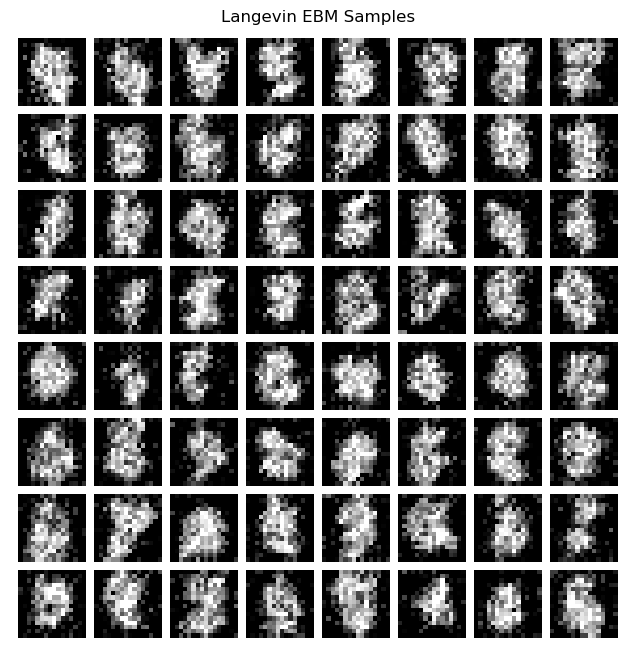

In [18]:
# changing a few hyperparameters - to get even better results. I played with both Gibbs and langevian for a while and found that both these models are 
# extremely sensetive to hyperparameters. I was able to get much better results by changing the following hyperparameters for langevian and gibbs above
# I found some github repos linked below which helped me find these hyperparameters

DEVICE = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.backends.mps.is_available()
                      else 'cpu')
BATCH_SIZE  = 64
EPOCHS      = 5
LR          = 2e-3       # smaller learning rate for stability
WEIGHT_DECAY= 1e-5       # mild L2 regularization
NUM_TRAIN   = 7291       # USPS train set size (approx)
IMAGE_SIZE  = 16         # USPS images 16x16
CHANNELS    = 1
MCMC_STEPS  = 15         # steps of Langevin each minibatch
LANGEVIN_STEP = 0.14    # smaller step size in training
CLIP_GRAD   = 5.0        # gradient norm clipping

print("Using device:", DEVICE)


class EnergyModel(nn.Module):
    """
    A small CNN that outputs a single scalar E(x). Lower => more likely x.
    We use LeakyReLU to reduce saturation. 
    """
    def __init__(self):
        super().__init__()
        # Fewer channels to keep the model from blowing up quickly
        self.conv1 = nn.Conv2d(CHANNELS, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        # final linear after global average
        self.fc    = nn.Linear(32, 1, bias=False)

    def forward(self, x):
        """
        x: [B,1,16,16]
        returns scalar energies shape [B]
        """
        h = F.leaky_relu(self.conv1(x), 0.2)  # smaller slope helps
        h = F.leaky_relu(self.conv2(h), 0.2)
        # global average pool => [B,32]
        h = h.mean(dim=[2,3])
        # final linear => shape [B]
        out = self.fc(h).squeeze(-1)
        return out  # E(x)



class LangevinSampler:
    """
    x_{t+1} = x_t - 0.5 * step_size * grad(E) + sqrt(step_size)*noise
    Then clamp to [0,1].
    """
    def __init__(self, model: nn.Module, step_size: float=0.01, clip: bool=True):
        self.model = model
        self.step_size = step_size
        self.clip = clip

    def sample(self, x0: torch.Tensor, steps: int=10) -> torch.Tensor:
        """
        x0: [B,1,H,W] in [0,1]
        steps: number of Langevin updates
        """
        self.model.eval()

        x = x0.clone().detach().to(DEVICE)
        x.requires_grad_(True)

        for _ in range(steps):
            energy = self.model(x).sum()
            energy.backward()

            with torch.no_grad():
                grad = x.grad
                # x <- x - 0.5 * step_size * grad(E) + sqrt(step_size)*noise
                x.data = x.data - 0.5 * self.step_size * grad
                x.data += math.sqrt(self.step_size) * torch.randn_like(x)
                if self.clip:
                    x.data.clamp_(0., 1.)

            x.grad.zero_()

        x.requires_grad_(False)
        return x.detach()


class PersistentBuffer:
    """
    Holds negative samples across iterations so they don't re-initialize every time.
    """
    def __init__(self, size, shape, device=DEVICE):
        self.size = size
        self.device = device
        # initialize random [0,1]
        self.buffer = torch.rand(size, *shape, device=device)

    def get(self, batch_size):
        idx = torch.randint(0, self.size, (batch_size,), device=self.device)
        return self.buffer[idx].clone(), idx

    def put(self, x_new, idx):
        self.buffer[idx] = x_new


def train_ebm(model, loader, optimizer, buffer, sampler, mcmc_steps=10, epochs=5):
    """
    L = E_data(E(x_data)) - E_model(E(x_neg)), done with persistent CD.
    We do gradient clipping + weight decay for stability.
    """
    model.to(DEVICE)
    model.train()

    for epoch in range(1, epochs+1):
        total_loss = 0.0
        total_count= 0
        pbar = tqdm(loader, desc=f"Epoch {epoch}/{epochs}", leave=False)

        for real_x, _ in pbar:
            real_x = real_x.to(DEVICE)

            B = real_x.size(0)
            E_pos = model(real_x).mean()

            # get negatives from buffer
            x_neg, idx = buffer.get(B)
            # MCMC update
            x_neg = sampler.sample(x_neg, steps=mcmc_steps)
            # store back
            buffer.put(x_neg, idx)

            E_neg = model(x_neg).mean()

            loss = E_pos - E_neg  # want to minimize (E_pos - E_neg) => maximize E_neg
            optimizer.zero_grad()
            loss.backward()

            # gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)
            optimizer.step()

            total_loss += loss.item()*B
            total_count+= B

        avg_loss = total_loss / total_count
        print(f"[Epoch {epoch}/{epochs}] Avg Loss = {avg_loss:.4f}")



@torch.no_grad()
def show_images_grid(tensor_images, nrow=8, title="Samples"):
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid

    tensor_images = tensor_images[:(nrow*nrow)]
    grid = make_grid(tensor_images.cpu(), nrow=nrow, padding=2, pad_value=1.0)
    npgrid = grid.permute(1,2,0).numpy()

    plt.figure(figsize=(nrow, nrow))
    if npgrid.shape[-1] == 1:
        plt.imshow(npgrid[...,0], cmap='gray', vmin=0, vmax=1)
    else:
        plt.imshow(npgrid)
    plt.title(title)
    plt.axis('off')
    plt.show()


transform_flt = transforms.ToTensor()
train_data_flt = datasets.USPS(root='.', train=True, download=True, transform=transform_flt)
loader_flt = DataLoader(train_data_flt, batch_size=BATCH_SIZE, shuffle=True)


model = EnergyModel()
# use a little weight decay for stability
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


buffer = PersistentBuffer(size=NUM_TRAIN, shape=(1,IMAGE_SIZE,IMAGE_SIZE), device=DEVICE)


sampler = LangevinSampler(model, step_size=LANGEVIN_STEP)

train_ebm(
    model=model,
    loader=loader_flt,
    optimizer=optimizer,
    buffer=buffer,
    sampler=sampler,
    mcmc_steps=MCMC_STEPS,
    epochs=EPOCHS
)

sampler.step_size = 0.04  # reduce further at test time
init_x = torch.rand(64, 1, IMAGE_SIZE, IMAGE_SIZE)
samples = sampler.sample(init_x, steps=50)
show_images_grid(samples, nrow=8, title="Langevin EBM Samples")


# Comparison Between the Two Results

I also looked at these links:
- [MNIST Distribution Training Script](https://github.com/raoulnormand/mnist_distribution/blob/master/training_script_only_3.py)
- [Langevin Sampler by HoeflerMatthias](https://github.com/HoeflerMatthias/langevin/blob/main/Langevin.py)
- [Generative Modeling Zoo (Duke University PhD student)](https://github.com/elliothha/generative-modeling-zoo)

**Notes:**
- These models appear to be extremely sensitive to hyperparameters, which is probably why they are not widely used in industry.
- Although it is possible to achieve excellent results with these models, it is unexpected because they are very sensitive to both the training procedure and the data.
- For reference, the same code can yield drastically different results depending on how many times it is run.  
  ![Another Run](another_run.png)  
  This image shows an alternate run.
- Additionally, the checkerboard pattern is a well-known failure mode for Langevin models.